# DamageBayes

DamageBayes implements a Bayesian MCMC approach using PyMC to estimate damage decay patterns in ancient DNA 
from high-throughput sequencing data. It evaluates the frequency of:
- C to T transitions at the 5' end 
- G to A transitions from the 3' end 

These subsitutions are canonical indicators of postmortem cytosine deamination, and the script provides 
interpretable decay curves and posterior estimates for each sample. 

## Workflow Overview

### 1. Importing Libraries

The script uses:

- **`pymc`** for Bayesian inference  
- **`arviz`** for posterior analysis  
- **`matplotlib`** for plotting  
- **`pandas`** and **`numpy`** for data handling  
- **`PdfPages`** (from `matplotlib.backends`) to compile plots into a multi-page PDF  

---

### 2. Defining the Model: `run_damage_model()`

This function:

- Takes a sample’s name, position array, and damage counts (`success_counts` and `fail_counts`)
- Computes total reads per position as `N_total = success + fail`
- Uses PyMC to model the **probability of damage at each read position $i$** using an exponential decay function:

  $$
  p_i = \alpha \cdot e^{-\beta(i - 1)}
  $$

  where:
  - $\alpha$ is the damage rate at the read end  
  - $\beta$ is the rate of exponential decay further into the read

- Performs MCMC sampling (500 draws, 250 tuning steps) to estimate posterior distributions of $\alpha$ and $\beta$
- Computes expected damage probabilities from positions 2 to 25, along with 95% credible intervals

The function returns a plot showing:

- The mean estimated decay curve
- Shaded regions representing the 95% credible interval for damage rates

---

### 3. Pairing and Parsing Input Files

Sample-specific input files are matched using:

```python
files_5 = glob(...*_5_end_freq)
files_3 = glob(...*_3_end_freq)
```

---

### 4. Generating Sample-Specific Damage Models

The script loops through each paired sample and performs the following:

- **Loads** the 5′ and 3′ frequency tables using `pandas`
- **Subsets** to positions 2–10, where ancient DNA damage is typically most concentrated
- **Extracts** base frequency data:
  - From the **5′ end**: C and T frequencies  
  - From the **3′ end**: G and A frequencies
- **Runs** the `run_damage_model()` function on each end independently to estimate the decay curve
- **Saves** both plots (5′ and 3′) to a shared multi-page PDF file using `PdfPages`

Each page in the PDF corresponds to a single sample, with both decay curves rendered side by side.

---

### 5. Output

The output consists of a single file:

📄 **`mcmc_damage_summary.pdf`**  

Each page includes:

- **Left Panel:** C→T damage decay curve from the 5′ end
- **Right Panel:** G→A damage decay curve from the 3′ end

This provides a quick and interpretable summary of whether postmortem deamination patterns are consistent with expectations for authentic ancient DNA.

---

### ✅ Advantages of This Approach

- Does **not require a reference genome** — models damage based on observed base frequencies  
- Simultaneously estimates both:
  - **Initial damage rate** ($\alpha$)  
  - **Decay rate** into the read ($\beta$)  
- Offers a **posterior probability framework** with uncertainty estimates via MCMC  
- Replaces or complements tools like *mapDamage* for **species-agnostic authentication**
- Scalable across multiple samples and easily extendable to downstream filtering or stratification  
- Works well even for **low-coverage or poorly preserved** ancient DNA samples  



### Calculate nucleotide frequencies

In [ ]:
# Parameters
N_bp=25      # Number of terminal bases to analyze
TRIM=1       # Bases to trim before analysis

# Function to count A/T/C/G at 5' and 3' ends
Count_ATCG() {
  FILE=$1
  N_bp=$2
  TRIM=$3

  awk -v n_bp="$N_bp" -v trim="$TRIM" \
      -v out5="${FILE/.fastq}_5_end_freq" \
      -v out3="${FILE/.fastq}_3_end_freq" '
    BEGIN {
      print "Position_from_5end\tA_freq\tT_freq\tC_freq\tG_freq\tTotal" > out5
      print "Position_from_3end\tA_freq\tT_freq\tC_freq\tG_freq\tTotal" > out3
    }
    NR % 4 == 2 {
      seq = $0
      len = length(seq)
      for (i = trim + 1; i <= n_bp; i++) {
        base5 = substr(seq, i, 1)
        base3 = substr(seq, len - i + 1, 1)
        count5[i][base5]++
        count3[i][base3]++
        total5[i]++
        total3[i]++
      }
    }
    END {
      for (i = trim + 1; i <= n_bp; i++) {
        printf "%d\t%d\t%d\t%d\t%d\t%d\n", i, count5[i]["A"]+0, count5[i]["T"]+0, count5[i]["C"]+0, count5[i]["G"]+0, total5[i]+0 >> out5
        printf "%d\t%d\t%d\t%d\t%d\t%d\n", i, count3[i]["A"]+0, count3[i]["T"]+0, count3[i]["C"]+0, count3[i]["G"]+0, total3[i]+0 >> out3
      }
    }
  ' "$FILE"
}

# Run function on all fastq files in directory
for FILE in *.fastq; do
  echo "Processing $FILE..."
  Count_ATCG "$FILE" "$N_bp" "$TRIM"
done

echo "Calculate nucleotide frequencies complete."

### Run DamageBayes on one sample

In [2]:
import pandas as pd

# Load the frequency tables for 3' and 5' end damage
file_3_end = "ERR5729614_filtered_25bp_100k_3_end_freq"
file_5_end = "ERR5729614_filtered_25bp_100k_5_end_freq"

# Try reading with tab separator
df_3 = pd.read_csv(file_3_end, sep="\t")
df_5 = pd.read_csv(file_5_end, sep="\t")

# Show the first five rows 
df_3.head(), df_5.head()

/home/slwrigh4/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


(   Position_from_3end   A_freq  T_freq   C_freq  G_freq    Total
 0                   2   970285  908062  1075987  821809  3776168
 1                   3  1184892  888169   859117  843958  3776168
 2                   4  1104106  884936   878598  908526  3776168
 3                   5  1010659  847260  1020665  897582  3776168
 4                   6  1001969  939527   937395  897271  3776168,
    Position_from_5end  A_freq   T_freq  C_freq   G_freq    Total
 0                   2  783360  1290326  679648  1022800  3776168
 1                   3  908653  1094205  849649   923661  3776168
 2                   4  902526  1139356  869471   864815  3776168
 3                   5  872882  1058920  888168   956198  3776168
 4                   6  890812  1039083  880326   965947  3776168)

In [3]:
# binomtest() performs a binomial hypothesis test
# in this case, it tests whether the number of "successes" (i.e., DNA base calls) in a fixed number of independent Bernoulli trials is consistent with a specified probability of success 
# C-->T transitions at reads ends are enriched and G-->A transitions on the reverse strand are elevated
from scipy.stats import binomtest


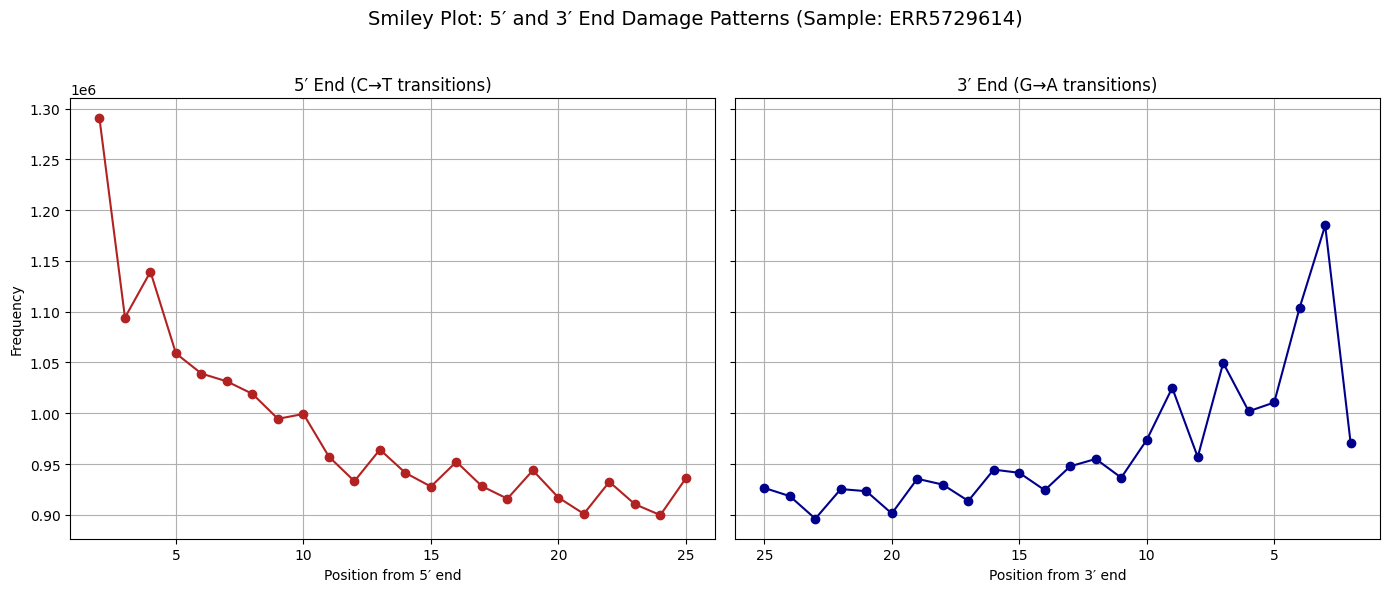

In [6]:
import matplotlib.pyplot as plt

# Subset the 5' end data to positions 2 to 25
df_5_plot = df_5[(df_5['Position_from_5end'] >= 2) & (df_5['Position_from_5end'] <= 25)].copy()

# Subset the 3' end data to positions 2 to 25
df_3_plot = df_3[(df_3['Position_from_3end'] >= 2) & (df_3['Position_from_3end'] <= 25)].copy()

# Create side-by-side plots like in mapDamage (smiley plot layout)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 5' end plot: T_freq vs position
ax1.plot(df_5_plot['Position_from_5end'], df_5_plot['T_freq'], marker='o', color='firebrick')
ax1.set_xlabel("Position from 5′ end")
ax1.set_ylabel("Frequency")
ax1.set_title("5′ End (C→T transitions)")
ax1.grid(True)

# 3' end plot: A_freq vs position (in reversed x to mirror orientation)
ax2.plot(df_3_plot['Position_from_3end'], df_3_plot['A_freq'], marker='o', color='darkblue')
ax2.set_xlabel("Position from 3′ end")
ax2.set_title("3′ End (G→A transitions)")
ax2.grid(True)

# Flip the x-axis of the 3' end so both plots mirror inward (smiley layout)
ax2.invert_xaxis()

plt.suptitle("Smiley Plot: 5′ and 3′ End Damage Patterns (Sample: ERR5729614)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pymc as pm
import arviz as az

def run_damage_model(sample_name, positions, success_counts, fail_counts, label, color):
    N_total = success_counts + fail_counts

    with pm.Model() as model:
        alpha = pm.Beta('alpha', alpha=1, beta=1)
        beta = pm.HalfNormal('beta', sigma=1)
        p = alpha * pm.math.exp(-beta * (positions - 1))
        obs = pm.Binomial('obs', n=N_total, p=p, observed=success_counts)

        trace = pm.sample(
            draws=500,
            tune=250,
            target_accept=0.9,
            cores=1,
            progressbar=False,
            return_inferencedata=True
        )

    posterior_samples = trace.posterior.stack(samples=("chain", "draw"))
    alpha_samples = posterior_samples["alpha"].values
    beta_samples = posterior_samples["beta"].values

    pos_range = np.arange(2, 26)
    mean_p, hdi_lower, hdi_upper = [], [], []

    for i in pos_range:
        probs = alpha_samples * np.exp(-beta_samples * (i - 1))
        mean_p.append(np.mean(probs))
        hdi = az.hdi(probs, hdi_prob=0.95)
        hdi_lower.append(hdi[0])
        hdi_upper.append(hdi[1])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(pos_range, mean_p, color=color, label=f"{label} estimate")
    ax.fill_between(pos_range, hdi_lower, hdi_upper, color=color, alpha=0.3, label="95% Credible Interval")
    ax.set_xlabel("Position from read end")
    ax.set_ylabel("Damage rate")
    ax.set_title(f"{label} decay model – {sample_name}")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    return fig

# Pair 5' and 3' end files
files_5 = sorted(glob("/mnt/c/Users/slwrigh4/ASU Dropbox/Sterling Wright/PC/Desktop/PSU/Romania/03_UPDATED_ANALYSES_COMPLETE_DATASET/07_ChangePoint/freq/*_5_end_freq"))
files_3 = sorted(glob("/mnt/c/Users/slwrigh4/ASU Dropbox/Sterling Wright/PC/Desktop/PSU/Romania/03_UPDATED_ANALYSES_COMPLETE_DATASET/07_ChangePoint/freq/*_3_end_freq"))

paired_samples = [
    (os.path.basename(f5).replace("_5_end_freq", ""), f5, f3)
    for f5, f3 in zip(files_5, files_3)
    if os.path.basename(f5).replace("_5_end_freq", "") == os.path.basename(f3).replace("_3_end_freq", "")
]

# Output PDF
output_pdf = "/mnt/c/Users/slwrigh4/ASU Dropbox/Sterling Wright/PC/Desktop/PSU/Romania/03_UPDATED_ANALYSES_COMPLETE_DATASET/07_ChangePoint/freq/mcmc_damage_summary.pdf"
with PdfPages(output_pdf) as pdf:
    for sample, file_5, file_3 in paired_samples:
        try:
            df_5 = pd.read_csv(file_5, sep="\t")
            df_3 = pd.read_csv(file_3, sep="\t")

            # 5' end
            df5sub = df_5[df_5['Position_from_5end'].between(2, 10)]
            pos5 = df5sub['Position_from_5end'].values
            T = df5sub['T_freq'].values
            C = df5sub['C_freq'].values
            fig_ct = run_damage_model(sample, pos5, T, C, label="C→T (5′)", color="firebrick")
            pdf.savefig(fig_ct)
            plt.close(fig_ct)

            # 3' end
            df3sub = df_3[df_3['Position_from_3end'].between(2, 10)]
            pos3 = df3sub['Position_from_3end'].values
            A = df3sub['A_freq'].values
            G = df3sub['G_freq'].values
            fig_ga = run_damage_model(sample, pos3, A, G, label="G→A (3′)", color="darkblue")
            pdf.savefig(fig_ga)
            plt.close(fig_ga)

        except Exception as e:
            print(f"Error processing {sample}: {e}")